In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.serialize import model_to_json
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics



/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/combined_data.csv')
df = df.sort_index()
df.set_index('Date', inplace=True)
df['lag_weekly_sales'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)
df.reset_index(inplace=True)
df = df.dropna(subset=['lag_weekly_sales'])


In [3]:
store_data = df[['Date', 'Weekly_Sales', 'Size','Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales']]
store_data.columns = ['ds', 'y', 'Size', 'Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales'] 
regressors = ['Size','Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales']

In [4]:
new_years = pd.DataFrame({
'holiday': 'new_year',
'ds': pd.to_datetime(['2010-12-31', '2011-12-30']),
})
thanksgiving = pd.DataFrame({
'holiday': 'thanksgiving',
'ds': pd.to_datetime(['2010-11-26', '2011-11-25']),
'lower_window': -5,
'upper_window': 5,
})
superbowls = pd.DataFrame({
'holiday': 'superbowl',
'ds': pd.to_datetime(['2010-02-12', '2012-02-10', '2011-02-11']),
'lower_window': -5,
'upper_window': 5,
})
labor_days = pd.DataFrame({
'holiday': 'labor_day',
'ds': pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07']),
'lower_window': -5,
'upper_window': 5,
})
holidays = pd.concat((new_years, superbowls, thanksgiving,labor_days))

In [5]:
model = Prophet(holidays=holidays, holidays_prior_scale = 50)
model.add_country_holidays(country_name='US')
for regressor in regressors:
    model.add_regressor(regressor)


In [6]:
markDowns = ['MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for markdown in markDowns:
    store_data[markdown].fillna(value=store_data[markdown].mean() , inplace=True) 

/var/folders/8g/hxdrgzwn3hj4nvsz61s8r23m0000gn/T/ipykernel_58107/4080054981.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_data[markdown].fillna(value=store_data[markdown].mean() , inplace=True)
/var/folders/8g/hxdrgzwn3hj4nvsz61s8r23m0000gn/T/ipykernel_58107/4080054981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_data[

In [7]:
train, test = train_test_split(store_data, test_size=0.2, random_state=42)


In [8]:
model.fit(train)


16:01:35 - cmdstanpy - INFO - Chain [1] start processing
16:03:26 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
forecast = model.predict(test)


In [10]:
test = test.sort_values(by='ds', ascending=True)


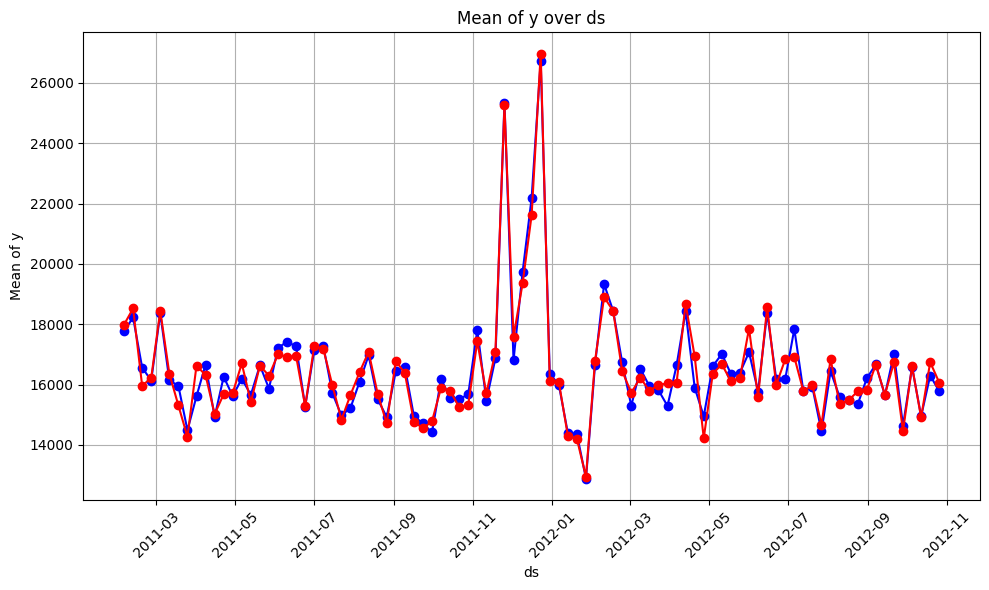

In [11]:
test['ds'] = pd.to_datetime(test['ds'])
df_grouped = test.groupby('ds', as_index=False)['y'].mean()
forecast['ds'] = pd.to_datetime(forecast['ds'])
df_forecast_grouped = forecast.groupby('ds', as_index=False)['yhat'].mean()
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['ds'], df_grouped['y'], marker='o', linestyle='-', color='b')
plt.plot(df_forecast_grouped['ds'], df_forecast_grouped['yhat'], marker='o', linestyle='-', color='r')
plt.title('Mean of y over ds')
plt.xlabel('ds')
plt.ylabel('Mean of y')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
single_store = store_data[(store_data['Store'] == 1) & (store_data['Dept'] == 1)]
single_store = single_store.sort_values(by='ds', ascending=True)
last_row = single_store.tail(1)
last_date = pd.to_datetime(last_row['ds'].iloc[0])
last_rows = pd.DataFrame({
    'ds': [last_date + pd.DateOffset(weeks=i) for i in range(1, 53)]
})
last_rows = last_rows.join(single_store.tail(52).reset_index(drop=True).drop(columns=['ds']))
result_df = last_rows

In [13]:
predictions = model.predict(result_df)

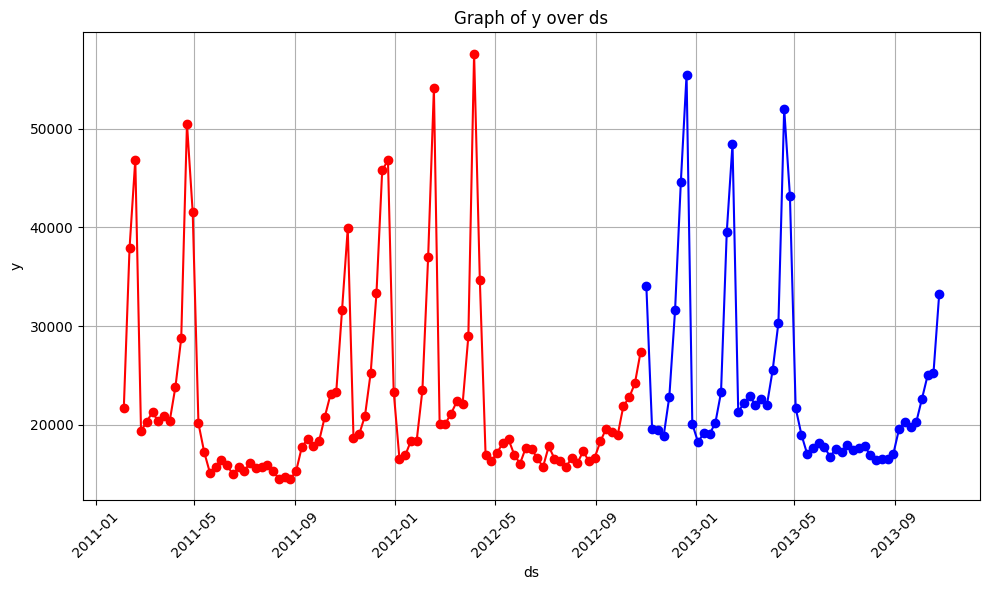

In [14]:
predictions['ds'] = pd.to_datetime(predictions['ds'])
single_store['ds'] = pd.to_datetime(single_store['ds'])
plt.figure(figsize=(10, 6))
plt.plot(single_store['ds'], single_store['y'], marker='o', linestyle='-', color='r')
plt.plot(predictions['ds'], predictions['yhat'], marker='o', linestyle='-', color='b')
plt.title('Graph of y over ds')
plt.xlabel('ds')
plt.ylabel('y')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
regressor_coef = regressor_coefficients(model)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

,regressor,regressor_mode,coef
8,week,additive,-103.523221
1,Store,additive,-4.027556
3,MarkDown1,additive,-0.014302
0,Size,additive,0.001834
5,MarkDown3,additive,0.002075
6,MarkDown4,additive,0.009495
4,MarkDown2,additive,0.021526
7,MarkDown5,additive,0.030042
11,lag_weekly_sales,additive,0.988935
2,Dept,additive,11.084178


In [16]:
df_cv = cross_validation(model, initial='300 days', period='30 days', horizon = '180 days')
df_p = performance_metrics(df_cv)


  0%|          | 0/6 [00:00<?, ?it/s]16:03:39 - cmdstanpy - INFO - Chain [1] start processing
16:04:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [01:07<05:35, 67.05s/it]16:04:46 - cmdstanpy - INFO - Chain [1] start processing
16:05:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [02:00<03:56, 59.24s/it]16:05:40 - cmdstanpy - INFO - Chain [1] start processing
16:06:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [02:53<02:49, 56.36s/it]16:06:34 - cmdstanpy - INFO - Chain [1] start processing
16:07:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [03:49<01:51, 55.99s/it]16:07:30 - cmdstanpy - INFO - Chain [1] start processing
16:08:18 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [04:55<00:59, 59.57s/it]16:08:36 - cmdstanpy - INFO - Chain [1] start processing
16:09:10 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [05:48<00:00, 58.09s/it]


In [20]:
df_p.head(180)

,horizon,mse,rmse,mae,mdape,smape,coverage
0,19 days,1.232702e+09,35109.861286,14640.314646,0.218122,0.589477,0.794115
1,20 days,1.851358e+09,43027.410244,20838.514444,0.260933,0.694470,0.734019
2,21 days,1.853728e+09,43054.947206,20866.558155,0.267145,0.693297,0.733683
3,22 days,1.857243e+09,43095.738021,20969.753312,0.264731,0.689210,0.730743
4,23 days,1.488566e+09,38581.935447,17247.655253,0.235561,0.625532,0.766792
...,...,...,...,...,...,...,...
134,175 days,3.080105e+09,55498.695491,33713.826463,0.945871,1.057514,0.672768
135,176 days,3.600965e+09,60008.039623,39248.842040,1.470557,1.145117,0.609471
136,177 days,3.160354e+09,56217.025586,35001.510739,1.046986,1.074783,0.651871
137,179 days,2.945635e+09,54273.705935,33173.297809,1.004159,1.088937,0.673176


In [17]:
with open('../src/models/prophet_1_year.json', 'w') as fout:
    fout.write(model_to_json(model))  
